In [1]:
import pandas as pd 
import numpy as np
import random
import os 
import re
import time
import math
import argparse
import pymysql
import json
import torch
import pickle
import time
import matplotlib.pyplot as plt
from torchmetrics import R2Score
from torch import nn
from fastprogress.fastprogress import master_bar, progress_bar
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from attrdict import AttrDict
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification
from transformers import BertConfig, BertTokenizer, BertModel
from transformers.optimization import get_cosine_schedule_with_warmup
from sklearn.metrics import precision_score , recall_score , confusion_matrix, f1_score, classification_report

In [2]:
data_path = "/home/cori/AuD/model1-2/data"
base_model_path = "/home/cori/AuD/base-model"
save_model_path = "/home/cori/AuD/model1-2/model"
config_path = "/home/cori/AuD/model1-2/config"
log_path = "/home/cori/AuD/model1-2/log"
config_file = "bert-base.json"

In [3]:
label = dict()

label[0] = '우울'
label[1] = '무기력'
label[2] = '급격한 체중(식욕)변화'
label[3] = '수면장애'
label[4] = '정서불안'
label[5] = '피로'
label[6] = '과도한 죄책감 및 무가치함'
label[7] = '인지기능저하'
label[8] = '자살충동'
label[9] = '일상'
label

{0: '우울',
 1: '무기력',
 2: '급격한 체중(식욕)변화',
 3: '수면장애',
 4: '정서불안',
 5: '피로',
 6: '과도한 죄책감 및 무가치함',
 7: '인지기능저하',
 8: '자살충동',
 9: '일상'}

In [4]:
with open(os.path.join(config_path, 'training_config.json')) as f:
    training_config = AttrDict(json.load(f))
    
training_config.pad = 'max_length'
training_config.device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [5]:
class BertDataset(Dataset):
    def __init__(self, data_file):
        self.data = data_file
    
    def __len__(self):
        return len(self.data.label)
    
    def reset_index(self):
        self.data.reset_index(inplace=True, drop=True)
    
    # def clear_text(self)  => 전처리 코드를 여기에 넣을 경우 상당히 느려짐
    
    def __getitem__(self, idx):
        '''
        return text, label
        '''
        self.reset_index()
        text = self.data.text[idx]
        label = self.data.label[idx]
        return text, label

In [6]:
class BertRegressor(nn.Module):
    def __init__(self, config, model):
        super(BertRegressor, self).__init__()
        self.model = model
        self.linear = nn.Linear(config.hidden_size, 128)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, 1)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = outputs.last_hidden_state[:, 0, :]
        x = self.linear(logits)
        x = self.relu(x)
        score = self.out(x)
        return score 

In [7]:
class BertProcessor():
    def __init__(self, training_config, tokenizer, truncation=True):
        self.tokenizer = tokenizer 
        self.max_len = 128
        self.pad = training_config.pad
        self.batch_size = training_config.train_batch_size
        self.truncation = truncation
    
    def convert_data(self, data_file):
        context2 = None    # single sentence classification

        batch_encoding = self.tokenizer.batch_encode_plus(
            [(data_file[idx][0], context2) for idx in range(len(data_file))],   # text, 
            max_length = self.max_len,
            padding = self.pad,
            truncation = self.truncation
        )
        
        features = []
        for i in range(len(data_file)):
            inputs = {k: batch_encoding[k][i] for k in batch_encoding}
            try:
                inputs['label'] = data_file[i][1] 
            except:
                inputs['label'] = 0 
            features.append(inputs)
        
        all_input_ids = torch.tensor([f['input_ids'] for f in features], dtype=torch.long)
        all_attention_mask = torch.tensor([f['attention_mask'] for f in features], dtype=torch.long)
        all_token_type_ids = torch.tensor([f['token_type_ids'] for f in features], dtype=torch.long)
        all_labels = torch.tensor([f['label'] for f in features], dtype=torch.long)

        dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
        return dataset
    
    def convert_sentence(self, sent_list):   # 사용자 입력 문장 1개 -> 입력 형태 변환
        context2 = None 
        batch_encoding = self.tokenizer.batch_encode_plus(
            [(sent_list, context2)], max_length=self.max_len, padding=self.pad, truncation=self.truncation
        )
        
        features = []
        inputs = {k: batch_encoding[k][0] for k in batch_encoding}
        inputs['label'] = 0 
        features.append(inputs)

        input_id = torch.tensor([f['input_ids'] for f in features], dtype=torch.long)
        input_am = torch.tensor([f['attention_mask'] for f in features], dtype=torch.long)
        input_tts = torch.tensor([f['token_type_ids'] for f in features], dtype=torch.long)
        input_lb = torch.tensor([f['label'] for f in features], dtype=torch.long)
        dataset = TensorDataset(input_id, input_am, input_tts, input_lb)
        return dataset
    
    def shuffle_data(self, dataset, data_type):
        if data_type == 'train':
            return RandomSampler(dataset)
        elif data_type == 'eval' or data_type == 'test':
            return SequentialSampler(dataset)
        
    def load_data(self, dataset, sampler):
        return DataLoader(dataset, sampler=sampler, batch_size=self.batch_size)

In [8]:
class BertRegTester():
    def __init__(self, training_config, model):
        self.training_config = training_config
        self.model = model

    def get_label(self, test_dataloader, test_type):
        '''
        test_type: 0  -> Test dataset 
        test_type: 1  -> Test sentence
        '''
        preds = []
        labels = []

        for batch in test_dataloader:
            self.model.eval()   # self 안 붙이면 이상한 Output (BaseModelOutputWithPoolingAndCrossAttentions) 출력 
            batch = tuple(t.to(training_config.device) for t in batch)   # args.device: cuda 
            with torch.no_grad():
                inputs = {
                    "input_ids": batch[0],
                    "attention_mask": batch[1],
                    "token_type_ids": batch[2],
                }
                outputs = self.model(**inputs)
                if test_type == 0:
                    preds.extend(outputs.squeeze().detach().cpu().numpy())
                elif test_type == 1:
                    preds.extend(outputs[0].detach().cpu().numpy())            
            label = batch[3].detach().cpu().numpy()
            labels.extend(label)
        return preds, labels 

In [9]:
class BertClsTester():
    def __init__(self, training_config, model):
        self.training_config = training_config
        self.model = model

    def get_label(self, test_dataloader, test_type):
        '''
        test_type: 0  -> Test dataset 
        test_type: 1  -> Test sentence
        '''
        preds = []
        labels = []

        for batch in test_dataloader:
            self.model.eval()
            batch = tuple(t.to(self.training_config.device) for t in batch)   # args.device: cuda 
            with torch.no_grad():
                inputs = {
                    "input_ids": batch[0],
                    "attention_mask": batch[1],
                    "token_type_ids": batch[2],
                    "labels": batch[3]
                }
                outputs = self.model(**inputs)
                test_loss, logits = outputs[:2] 
                pred = logits.detach().cpu().numpy()
                if test_type == 0:
                    preds.extend(np.argmax(pred, axis=1))
                elif test_type == 1:
                    preds.append(np.argmax(pred))  
                            
            label = inputs["labels"].detach().cpu().numpy()
            labels.extend(label)
  
        return preds, labels 
    
    def get_f1_score(self, test_dataloader):
        y_pred, y_true = self.get_label(test_dataloader)
        return round(f1_score(y_true, y_pred, average='micro'), 3) 
     
    def get_cl_report(self, test_dataloader):
        y_pred, y_true = self.get_label(test_dataloader, 0)
        cr = classification_report(y_true, y_pred).split('\n')
        clr_df = []

        for idx, line in enumerate(cr):
            clr_df.append([])
            if line == '':
                continue

            word_list = line.strip().split(' ')

            for word in word_list:
                if word != '':
                    clr_df[idx].append(word)

        clr_df[-2][0] = ' '.join([clr_df[-2][0], clr_df[-2][1]])
        clr_df[-3][0] = ' '.join([clr_df[-3][0], clr_df[-3][1]])
        clr_df[-4].insert(1, ' ')
        clr_df[-4].insert(2, ' ')
        clr_df[0].insert(0, 'index')

        clr_df[-2].pop(1)
        clr_df[-3].pop(1)
        clr_df.pop(1)
        clr_df.pop(-1)
        clr_df.pop(-4)
        clr_df = pd.DataFrame(clr_df[1:], columns=clr_df[0])
        clr_df.index = clr_df['index']

        del clr_df['index']
        return clr_df

#### Regression Model

In [ ]:
X_test = pd.read_csv(os.path.join(data_path, 'bws_bin_samp_test.csv'))
X_test.head(3)

In [ ]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(model_path, 'bert-base'), model_max_length=32)
config = BertConfig.from_pretrained(os.path.join(model_path, 'bert-base', 'bert_config.json'))
model = BertModel.from_pretrained(os.path.join(model_path, 'bert-base'), config=config)

In [ ]:
test_processor = BertProcessor(training_config, tokenizer)

In [ ]:
test_file = BertDataset(X_test)
test_dataset = test_processor.convert_data(test_file)
test_sampler = test_processor.shuffle_data(test_dataset, 'test')
test_dataloader = test_processor.load_data(test_dataset, test_sampler)

In [ ]:
config.max_position_embeddings = 32

In [ ]:
model_reg = BertRegressor(config, model)

In [ ]:
model_name = os.path.join(model_path, 'bws', 'bert_bin_samp_base.pt')
# model_name = os.path.join(model_path, 'bws', 'bert_bws_medium.pt') 

In [ ]:
model_reg.load_state_dict(torch.load(model_name))
model_reg.to(training_config.device)

In [ ]:
bert_tester = BertRegTester(training_config, model_reg)

In [ ]:
start = time.time()
y_pred, y_true = bert_tester.get_label(test_dataloader, 0)
print(f'소요 시간: {time.time() - start}')

In [ ]:
X_test

In [ ]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [ ]:
criterion = RMSELoss

In [ ]:
loss = criterion(torch.Tensor(y_pred), torch.Tensor((y_true)))
loss

In [ ]:
r2score = R2Score()
r2score(torch.Tensor(y_pred), torch.Tensor(y_true))

In [ ]:
X_test.text[2]

In [ ]:
y_pred[:10], y_true[:10]

In [ ]:
test_sent = "I am so depressed today" # X_test.text[0]
test_data = test_processor.convert_sentence(test_sent)
test_sampler = test_processor.shuffle_data(test_data, 'test')
test_loader = test_processor.load_data(test_data, test_sampler)

In [ ]:
start = time.time()
y_pred, y_true = bert_tester.get_label(test_loader, 1)
print(f'소요 시간: {time.time() - start}')

In [ ]:
y_pred

In [ ]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(model_path, 'bert-mini'), model_max_length=32)
config = BertConfig.from_pretrained(os.path.join(model_path, 'bert-mini', 'bert_config.json'))
model = BertModel.from_pretrained(os.path.join(model_path, 'bert-mini'), config=config)

In [ ]:
conv = ['hey', 'I feel very depressed', 'I feed depressed', 'I feel sad', 'I cry everyday', 'I went to school', 'I want to die']
dep_test = pd.DataFrame(conv, columns=['text'])
dep_test['label'] = 9999

In [ ]:
test_file = BertDataset(dep_test)
test_dataset = test_processor.convert_data(test_file)
test_sampler = test_processor.shuffle_data(test_dataset, 'test')
test_dataloader = test_processor.load_data(test_dataset, test_sampler)

In [ ]:
model_reg = BertRegressor(config, model)
# model_reg2 = BertRegressor(config, model)

In [ ]:
model_name = os.path.join(model_path, 'bert_bws_best.pt')

In [ ]:
model_reg.load_state_dict(torch.load(model_name))
model_reg.to(training_config.device)

In [ ]:
bert_tester = BertTester(training_config, model_reg)

In [ ]:
y_pred, y_true = bert_tester.get_label(test_dataloader, 0)

In [ ]:
dep_test['label'] = [pred for pred in y_pred]
dep_test

#### Classification 

In [50]:
X_test = pd.read_csv(os.path.join(data_path, 'dsm_samp_test.csv'))
X_test.head(3)

,id,text,label
0,10iull,"i attempted suicide twice during this, and as ...",8
1,47ohkk,i just have a feeling of sadness constantly in...,0
2,107968,I think it'd be better to wear several thin cl...,9


In [11]:
X_test.label.unique()

array([3, 8, 0, 6, 1, 2, 7, 5, 4])

In [51]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(base_model_path, 'bert-mini'), model_max_length=128)
config = BertConfig.from_pretrained(os.path.join(base_model_path, 'bert-mini', 'bert_config.json'), num_labels=10, output_hidden_states=True)
model = BertForSequenceClassification.from_pretrained(os.path.join(base_model_path, 'bert-mini'), config=config)

Some weights of the model checkpoint at /home/cori/AuD/base-model/bert-mini were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification

In [52]:
config.max_position_embeddings = 128

In [53]:
with open(os.path.join(config_path, 'training_config.json')) as f:
    training_config = AttrDict(json.load(f))

training_config.pad = 'max_length'
training_config.device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
model.to(training_config.device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, element

In [54]:
test_processor = BertProcessor(training_config, tokenizer)

In [55]:
test_file = BertDataset(X_test)
test_dataset = test_processor.convert_data(test_file)
test_sampler = test_processor.shuffle_data(test_dataset, 'test')
test_dataloader = test_processor.load_data(test_dataset, test_sampler)

In [56]:
# model_name = os.path.join(save_model_path, 'label_10', 'bert-tiny', 'bert_dsm_8.pt')
model_name = os.path.join(save_model_path, 'label_10', 'bert-mini', 'bert_dsm_4.pt')
# model_name = os.path.join(save_model_path, 'label_10', 'bert-small', 'bert_dsm_4.pt')
# model_name = os.path.join(save_model_path, 'label_10', 'bert-medium', 'bert_dsm_6.pt')
# model_name = os.path.join(save_model_path, 'label_10', 'bert-base', 'bert_dsm_1.pt')

In [57]:
model.load_state_dict(torch.load(model_name))
model.to(training_config.device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, element

In [19]:
dsm_samp = X_test.copy()
dsm_samp = dsm_samp.sample(10)
dsm_samp.reset_index(inplace=True, drop=True)

In [58]:
bert_tester = BertClsTester(training_config, model)

In [21]:
start = time.time()
y_pred, y_true = bert_tester.get_label(test_dataloader, 0)
print(f'소요 시간: {time.time() - start}')

소요 시간: 8.876757860183716


In [22]:
from torchmetrics.classification import F1Score
from torchmetrics.classification import MulticlassPrecision
from torchmetrics.classification import MulticlassRecall
from torchmetrics.classification import MulticlassSpecificity

f1 = F1Score(task="multiclass", num_classes=len(X_test.label.unique()))
precision = MulticlassPrecision(num_classes=len(X_test.label.unique()))
recall = MulticlassRecall(num_classes=len(X_test.label.unique()))
specificity = MulticlassSpecificity(num_classes=len(X_test.label.unique()))

In [23]:
print(f'precision: {precision(torch.Tensor(y_pred), torch.Tensor(y_true))}')
print(f'recall: {recall(torch.Tensor(y_pred), torch.Tensor(y_true))}')
print(f'specificity: {specificity(torch.Tensor(y_pred), torch.Tensor(y_true))}')
print(f'f1-score: {f1(torch.Tensor(y_pred), torch.Tensor(y_true))}')

precision: 0.9994147419929504
recall: 0.9990890026092529
specificity: 0.9999389052391052
f1-score: 0.9995973706245422


In [ ]:
test_sent = "I can't sleep because I have too much work to do" # X_test.text[0]
test_data = test_processor.convert_sentence(test_sent)
test_sampler = test_processor.shuffle_data(test_data, 'test')
test_loader = test_processor.load_data(test_data, test_sampler)

In [ ]:
start = time.time()
y_pred2, y_true2 = bert_tester.get_label(test_loader, 1)
print(f'소요 시간: {time.time() - start}')

In [24]:
from sklearn.metrics import precision_score , recall_score , confusion_matrix, f1_score, classification_report

confusion_mt = pd.DataFrame(confusion_matrix(y_true, y_pred))
confusion_mt

,0,1,2,3,4,5,6,7,8
0,8000,0,0,0,0,0,0,0,0
1,0,414,0,2,0,0,0,0,0
2,1,1,1024,0,0,0,0,0,0
3,1,0,0,1445,0,0,0,0,0
4,0,0,0,0,143,0,0,0,0
5,0,0,0,0,0,348,0,0,0
6,1,0,0,0,0,0,3999,0,0
7,0,0,0,0,0,0,0,490,0
8,1,0,1,0,0,0,0,0,3998


In [ ]:
len(y_pred)

In [25]:
from sklearn.preprocessing import label_binarize 

y_true = label_binarize(y_true, classes=list(range(9)))
y_pred = label_binarize(y_pred, classes=list(range(9)))

In [26]:
from sklearn.metrics import roc_curve, auc

n_classes = 9
fpr = dict()
tpr = dict()
roc_auc = dict() 

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])

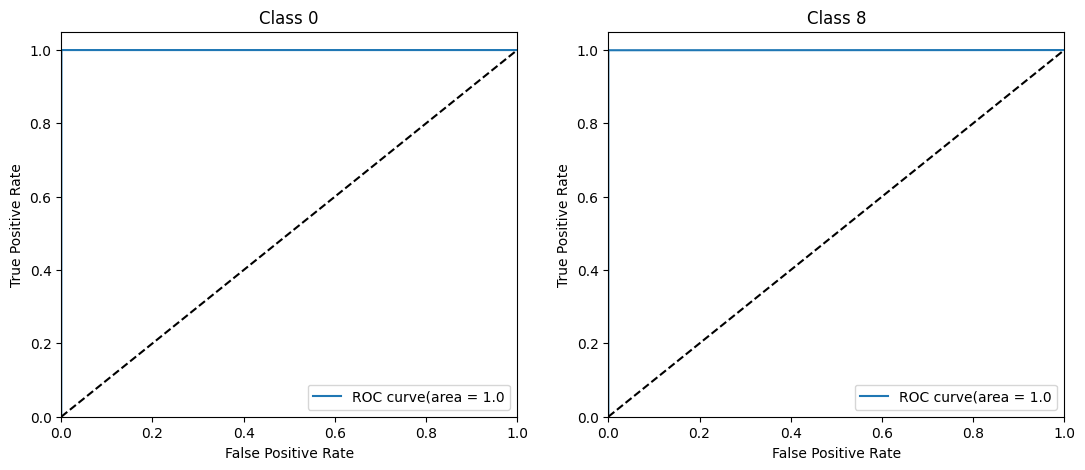

In [27]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(20, 5))
val = 0

for idx, i in enumerate(range(n_classes)):
    if idx == 0 or idx == 8 or idx == 9: 
        plt.subplot(131+val) 
        plt.plot(fpr[i], tpr[i], label = f'ROC curve(area = {round(roc_auc[i], 2)}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate') 
        plt.ylabel('True Positive Rate')
        plt.title(f'Class {idx}')
        plt.legend(loc='lower right')
        val += 1
plt.show()

#### 학습 기록 시각화 

In [ ]:
with open(os.path.join(log_path, 'label_10', 'bert-medium', 'train_11_acc.pickle'), 'rb') as f:
    train_acc = pickle.load(f)
    
with open(os.path.join(log_path, 'label_10', 'bert-medium', 'train_11_loss.pickle'), 'rb') as f:
    train_loss = pickle.load(f)
    
with open(os.path.join(log_path, 'label_10', 'bert-medium', 'eval_11_acc.pickle'), 'rb') as f:
    val_acc = pickle.load(f)

with open(os.path.join(log_path, 'label_10', 'bert-medium', 'eval_11_loss.pickle'), 'rb') as f:
    val_loss = pickle.load(f)

In [ ]:
num_epochs = list(range(len(train_acc)))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(list(range(len(train_acc))), train_acc, label='train_acc')
plt.plot(list(range(len(val_acc))), val_acc, label='val_acc')

plt.legend()
plt.show()

In [ ]:
num_epochs = list(range(len(train_acc)))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(list(range(len(val_acc))), train_loss, label='train_loss')
plt.plot(list(range(len(val_loss))), val_loss, label='val_loss')

plt.legend()
plt.show()

In [ ]:
train_loss[4], val_loss[4]

In [ ]:
train_loss[6], val_loss[6]

#### 가상 대화 예측 

In [ ]:
X_test

In [28]:
with open(os.path.join(data_path, 'conv_translated.pickle'), 'rb') as f:
    conv = pickle.load(f)
    
conv = conv[['speaker_idx', 'translated']]
conv.columns = ['speaker', 'text']
conv.head()

,speaker,text
0,User,hey
1,Chatbot,"Hello, nice to meet you"
2,User,what is your name ?
3,Chatbot,I am a psychological counseling chatbot
4,User,Ah-huh


In [29]:
conv.loc[6].text = 'I am so depressed today'
conv.loc[12]. text = 'I can not sleep because I have too much work to do'

In [30]:
user_conv = conv[conv.speaker=='User']
user_conv['label'] = 0

/tmp/ipykernel_7499/3381273535.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_conv['label'] = 0


In [44]:
user_conv = user_conv[['text', 'label']]

In [45]:
conv_file = BertDataset(user_conv)
conv_dataset = test_processor.convert_data(conv_file)
conv_sampler = test_processor.shuffle_data(conv_dataset, 'test')
conv_dataloader = test_processor.load_data(conv_dataset, conv_sampler)

In [59]:
cls_tester = BertClsTester(training_config, model)

In [60]:
y_pred, y_true = bert_tester.get_label(conv_dataloader, 0)

In [61]:
user_conv['label_10'] = y_pred
# user_conv.columns = ['text' ,'label_9']

In [62]:
user_conv

,text,label_9,label_10
0,hey,0,9
1,what is your name ?,0,9
2,Ah-huh,0,9
3,I am so depressed today,0,0
4,I just feel so lethargic these days,1,1
5,I think he's psychologically exhausted,0,9
6,I can not sleep because I have too much work t...,3,3
7,I should I'll go for a walk from time to time,0,9
8,Thanks for listening,0,9


In [64]:
user_conv.label_9 = user_conv.label_9.apply(lambda x: label[x])
user_conv.label_10 = user_conv.label_10.apply(lambda x: label[x])
user_conv

,text,label_9,label_10
0,hey,우울,일상
1,what is your name ?,우울,일상
2,Ah-huh,우울,일상
3,I am so depressed today,우울,우울
4,I just feel so lethargic these days,무기력,무기력
5,I think he's psychologically exhausted,우울,일상
6,I can not sleep because I have too much work t...,수면장애,수면장애
7,I should I'll go for a walk from time to time,우울,일상
8,Thanks for listening,우울,일상
